# Traffic Forecasting with Pytorch Geometric Temporal


## Installation

In [1]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

2.0.1+cu117


This took some time for me, so be patient :)

VERY IMPORTANT: all the dependencies need python 3.9!!

For pytorch with cuda, wheel can be found here: https://download.pytorch.org/whl/torch/

In [ ]:
!pip install pandas==1.3.5

In [8]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install torch-geometric-temporal
clear_output()

if previous line worked, then the next one should not be necessary

In [6]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
                                              0.0/499.9 kB ? eta -:--:--
                                              10.2/499.9 kB ? eta -:--:--
                                              10.2/499.9 kB ? eta -:--:--
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ---                                   41.0/499.9 kB 219.4 kB/s eta 0:00:03
     ------                                81.9/499.9 kB 255.1 kB/s eta 0:00:02
     -------                              102.4/499.9 kB 281.0 kB/s eta 0:00:02
     -------                              102.4/499.9 kB 281.0 kB/s eta 0:00:02
     --------                             112.6/499.9 kB 242.7 kB/s eta 0:00:02
     ---------------                      215.0/499.9 kB 452.1 kB/s eta 0:00:01
     ---------------                      215.0/499.9 kB 452.1 kB/s eta 0:0

## Dataset
- Traffic forecasting dataset based on Los Angeles Metropolitan traffic
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network


In [2]:
import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


In [3]:
import os
import zipfile
import numpy as np
import torch
from torch_geometric.utils import dense_to_sparse
from six.moves import urllib

class BICIMADloader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir, raw_data_name, adj_mat_name):
        self.raw_data_dir = raw_data_dir
        self.raw_data_name = raw_data_name
        self.adj_mat_name = adj_mat_name
        self._load_data()

    
    def _load_data(self):
        #loads data, already preprocessed and normalized!
        A = np.load(os.path.join(self.raw_data_dir, self.adj_mat_name))
        X = np.load(os.path.join(self.raw_data_dir, self.raw_data_name)).transpose(
            (1, 2, 0)
        ).astype(np.float32)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)
        

    def _get_edges_and_weights(self):
        #gets adjacency matrix and transforms it to correct format
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self,slide = 1, num_timesteps_in: int = 24, num_timesteps_out: int = 24):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i*slide, i*slide + (num_timesteps_in + num_timesteps_out))
            for i in range(int((self.X.shape[2] - (num_timesteps_in + num_timesteps_out))/slide))
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            #it assumes that first column will always be the target
            features.append((self.X[:, 1:, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, 0, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, slide = 1,num_timesteps_in: int = 24, num_timesteps_out: int = 24
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(slide,num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset


In [13]:

loader = BICIMADloader(raw_data_dir="data_bicimad", raw_data_name="train_plugs.npy",adj_mat_name="adj_mat.npy")
train_dataset = loader.get_dataset(slide=168,num_timesteps_in=168, num_timesteps_out=168)

In [6]:
dataset.snapshot_count

153

#### Data Sample
- 107 nodes
- 27 features per node (speed, time)
- 168 timesteps per bucket (7*24h = 1 week)
- Labels for 168 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between stations


In [14]:
# Show first sample
next(iter(train_dataset))

Data(x=[170, 27, 168], edge_index=[2, 28706], edge_attr=[28706], y=[170, 168])

NOTE: there is something wrong here because this plot and the one in preprocessing should be the same

<Axes: >

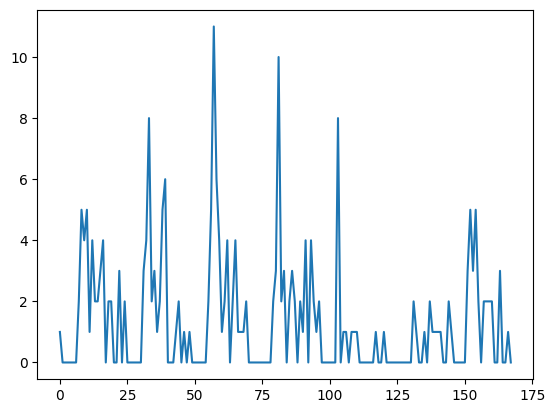

In [15]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 0
hours = 168
sensor_labels = [hour.item() for hour in list(train_dataset)[0].y[sensor_number][0:hours]]
sns.lineplot(data=sensor_labels)

#### Test Train Split

In [11]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

#print("Number of train buckets: ", len(set(train_dataset)))
#print("Number of test buckets: ", len(set(test_dataset)))

## Model

Which model to choose depends on which time-series task you work on.

- A3TGCN is an extension of TGCN that uses attention
- The spatial aggregation uses GCN, the temporal aggregation a GRU
- We can pass in periods to get an embedding for several timesteps
- This embedding can be used to predict several steps into the future = output dimension
- We could also do this in a loop and feed it again into the model (would be autoregressive)
- There is only one block here. Other layers also allow stacking???

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=27, periods=168)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(27, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(27, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(27, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=168, bias=True)
)

## Training

- Training on GPU didn't bring much speed-up
- I ran into RAM issues, why I only train on a smaller subset of the data

In [17]:
!nvidia-smi

Mon Jun 26 01:59:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P8              11W / 170W |   1136MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
# GPU support
from torch import nn

class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
    

device = torch.device('cuda') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=27, periods=168).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = RMSELoss().to(device)
model.train()

print("Running training...")
for epoch in range(3):
    print(epoch)

    j = 0
    for snapshot in train_dataset:
        j+=1
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        # we apply stochastic gradient descent(batch = 1)
        RMSE_loss = criterion(y_hat, snapshot.y)
        RMSE_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        print("week: {}/{}, train MSE: {:.4f}".format(j,train_dataset.snapshot_count, RMSE_loss.item()))

    
    
    print("Epoch {} train MSE: {:.4f}".format(epoch, RMSE_loss.item()))

Running training...
0
week: 1/153, train MSE: 3.6438
week: 2/153, train MSE: 3.9946
week: 3/153, train MSE: 3.7226
week: 4/153, train MSE: 3.9085
week: 5/153, train MSE: 4.0573
week: 6/153, train MSE: 4.0696
week: 7/153, train MSE: 4.0857
week: 8/153, train MSE: 3.9650
week: 9/153, train MSE: 4.1218
week: 10/153, train MSE: 4.0685
week: 11/153, train MSE: 4.0017
week: 12/153, train MSE: 3.4669
week: 13/153, train MSE: 3.6785
week: 14/153, train MSE: 2.4772
week: 15/153, train MSE: 3.4717
week: 16/153, train MSE: 3.3191
week: 17/153, train MSE: 4.1797
week: 18/153, train MSE: 4.0036
week: 19/153, train MSE: 4.2857
week: 20/153, train MSE: 5.9192
week: 21/153, train MSE: 4.9432
week: 22/153, train MSE: 6.6203
week: 23/153, train MSE: 5.9358
week: 24/153, train MSE: 3.6083
week: 25/153, train MSE: 3.7121
week: 26/153, train MSE: 2.8929
week: 27/153, train MSE: 2.0039
week: 28/153, train MSE: 2.0240
week: 29/153, train MSE: 2.5181
week: 30/153, train MSE: 2.7165
week: 31/153, train MSE: 2.

## Evaluation

- Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
- The model always gets one hour and needs to predict the next hour

In [29]:
model.eval()
loss = 0
step = 0
horizon = 10

loader = BICIMADloader(raw_data_dir="data_bicimad", raw_data_name="test_plugs.npy",adj_mat_name="adj_mat.npy")
test_dataset = loader.get_dataset(slide=168,num_timesteps_in=168, num_timesteps_out=168)
# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 4.7097


In [131]:
predictions[0].shape

torch.Size([170, 168])

### Visualization

- The further away the point in time is, the worse the predictions get
- Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [30]:
import numpy as np

sensor = 123
preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
print(preds.shape)
preds = preds.reshape((horizon+1)*168)
labs  = np.asarray([label[sensor].cpu().numpy() for label in labels])
labs = labs.reshape((horizon+1)*168)

print("Data points:,", preds.shape)

(11, 168)
Data points:, (1848,)


<Axes: >

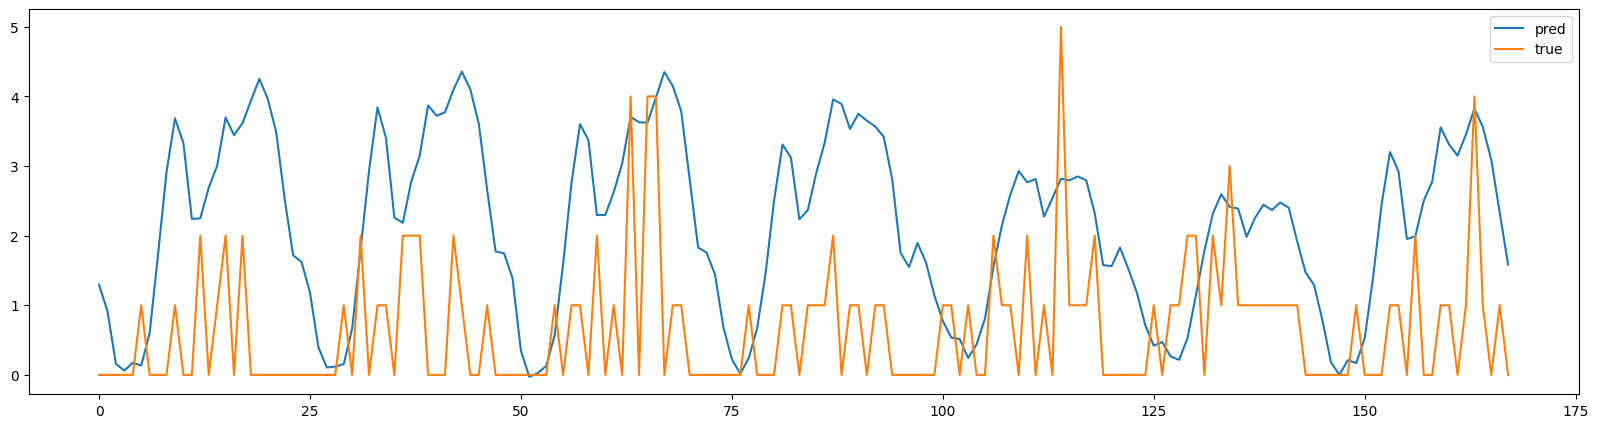

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds[168:168+168], label="pred")
sns.lineplot(data=labs[168:168+168], label="true")

In [32]:
import numpy as np

sensor = 9
#preds = np.asarray([pred[sensor].detach().cpu().numpy() for pred in predictions])
preds = np.asarray([pred.detach().cpu().numpy() for pred in predictions])
preds=preds.reshape((horizon+1,170,7,24))
preds = np.sum(preds, axis=1)
preds = np.sum(preds, axis=2)
preds=preds.reshape((horizon+1)*7)

labs = np.asarray([lab.detach().cpu().numpy() for lab in labels])
labs=labs.reshape((horizon+1,170,7,24))
labs = np.sum(labs, axis=1)
labs = np.sum(labs, axis=2)
labs=labs.reshape((horizon+1)*7)


In [ ]:
preds = preds.reshape((horizon+1)*168)
preds=preds.reshape((horizon+1,7,24))

preds = np.sum(preds, axis=2)
preds=preds.reshape((horizon+1)*7)

labs  = np.asarray([label[sensor].cpu().numpy() for label in labels])
labs = labs.reshape((horizon+1)*168)

labs=labs.reshape((horizon+1,7,24))

labs = np.sum(labs, axis=2)
labs=labs.reshape((horizon+1)*7)

print("Data points:,", preds.shape)

<Axes: >

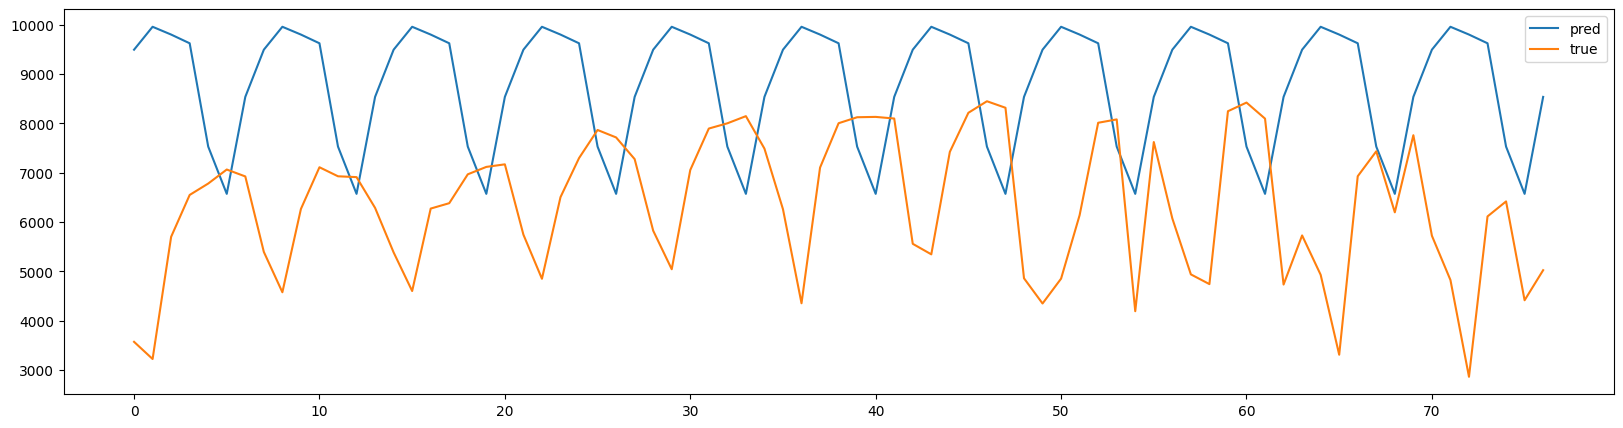

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")

# EXPLAINABILITY OF THE GNN!!!!

https://pytorch-geometric.readthedocs.io/en/latest/modules/explain.html?highlight=plot